<a href="https://colab.research.google.com/github/utkarsh0702/Tensorflow/blob/master/Time_Series_prediction1_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

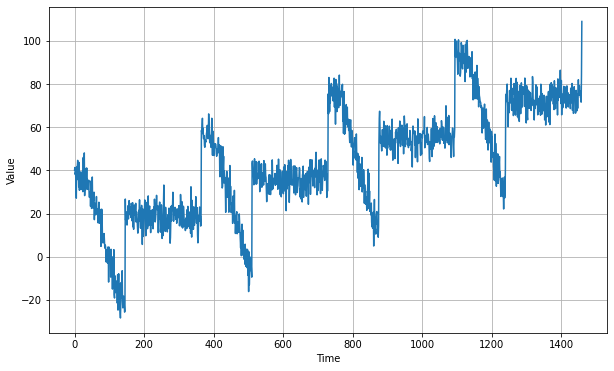

In [2]:
def plot_series(time, series,format='-', start=0, end=None):
	plt.plot(time[start:end], series[start:end], format)
	plt.xlabel('Time')
	plt.ylabel('Value')
	plt.grid(True)

def trend(time, slope=0):
	return time*slope

def seasonal_pattern(season_time):
	return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
	season_time= ((time+phase)%period)/period
	return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
	rnd= np.random.RandomState(seed)
	return rnd.randn(len(time))*noise_level

time= np.arange(4*365+1, dtype='float32')
baseline=0
series= trend(time, 0.1)
amplitude=40
slope=0.05
noise_level=5

series= baseline+trend(time, slope)+seasonality(time, period=365, amplitude= amplitude)
series+=noise(time, noise_level, seed=45)
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
	dataset= tf.data.Dataset.from_tensor_slices(series)
	dataset= dataset.window(window_size+1, shift=1, drop_remainder=True)
	dataset= dataset.flat_map(lambda x: x.batch(window_size+1))
	dataset= dataset.shuffle(shuffle_buffer).map(lambda x:(x[:-1], x[-1]))
	dataset= dataset.batch(batch_size).prefetch(1)
	return dataset

split= 1000
time_train=time[:split]
x_trin=series[:split]
time_valid=time[split:]
x_valid=series[split:]

window_size=20
batch_size=32
shuffle_buffer_size=1000

dataset= windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [4]:
model= keras.models.Sequential([
                                keras.layers.Dense(1, input_shape=[window_size])
])

model.compile(loss='mse', optimizer= keras.optimizers.SGD(lr= 1e-6, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.fit(dataset, epochs= 100, verbose=0)

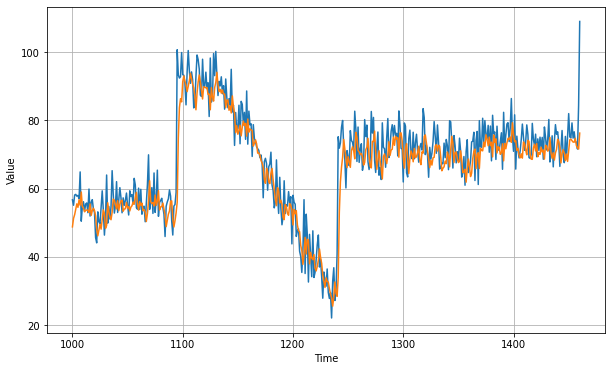

In [6]:
#Forecast prediction
forecast=[]
for time in range(len(series)- window_size):
	forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast= forecast[split- window_size:]
results= np.array(forecast)[:,0,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
#metrics
keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.997209